In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [12]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real AMAZON Stock Price')
    plt.plot(predicted, color='blue',label='Predicted AMAZON Stock Price')
    plt.title('AMAZON Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('AMAZON Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
# First, we get the data
dataset = pd.read_csv('../content/AMZN.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-26,3.431250,3.500000,3.237500,3.240625,3.240625,131160000
2000-01-27,3.259375,3.387500,3.231250,3.346875,3.346875,135680000
2000-01-28,3.250000,3.321875,3.000000,3.084375,3.084375,275558000
2000-01-31,3.018750,3.237500,2.921875,3.228125,3.228125,213958000
2000-02-01,3.375000,3.531250,3.218750,3.371875,3.371875,268092000


In [4]:
# Total length of the dataset
total_length = len(dataset)
print("Total length of the dataset:", total_length)


Total length of the dataset: 6079


##EDA

In [82]:
# Summary statistics
print(dataset.describe())


              Open         High          Low        Close    Adj Close  \
count  6079.000000  6079.000000  6079.000000  6079.000000  6079.000000   
mean     39.230451    39.694110    38.732538    39.224507    39.224507   
std      52.856399    53.472558    52.191951    52.836708    52.836708   
min       0.295500     0.305000     0.275500     0.298500     0.298500   
25%       2.280000     2.316562     2.237250     2.284187     2.284187   
50%      10.749500    10.869000    10.569500    10.736500    10.736500   
75%      72.637501    73.564247    71.363751    72.796002    72.796002   
max     187.199997   188.654007   184.839493   186.570496   186.570496   

             Volume  
count  6.079000e+03  
mean   1.205842e+08  
std    9.750804e+07  
min    1.762600e+07  
25%    6.490900e+07  
50%    9.866000e+07  
75%    1.451440e+08  
max    2.086584e+09  


In [95]:
!pip install mplfinance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.0 MB/s eta 0:00:00


In [98]:
print(dataset.columns)
print(dataset.head())


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '50MA'], dtype='object')
                Open      High       Low     Close  Adj Close     Volume  50MA
Date                                                                          
2000-01-26  3.431250  3.500000  3.237500  3.240625   3.240625  131160000   NaN
2000-01-27  3.259375  3.387500  3.231250  3.346875   3.346875  135680000   NaN
2000-01-28  3.250000  3.321875  3.000000  3.084375   3.084375  275558000   NaN
2000-01-31  3.018750  3.237500  2.921875  3.228125   3.228125  213958000   NaN
2000-02-01  3.375000  3.531250  3.218750  3.371875   3.371875  268092000   NaN


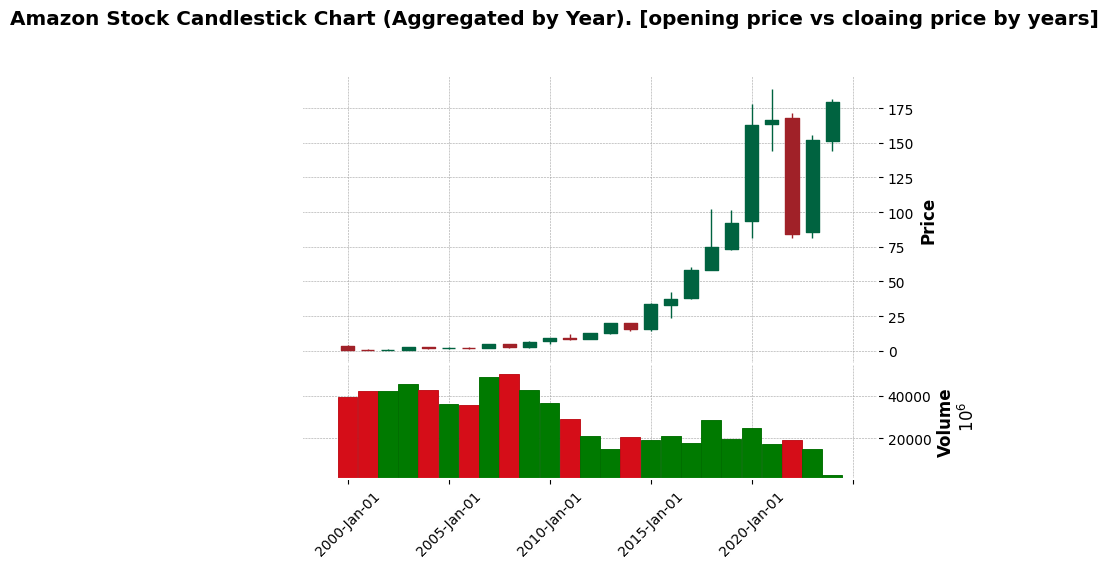

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

# Convert index to datetime object
dataset.index = pd.to_datetime(dataset.index)

# Extract year from the index
dataset['Year'] = dataset.index.year

# Group data by year and aggregate opening and closing prices
agg_data = dataset.groupby('Year').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})

# Convert index to DatetimeIndex
agg_data.index = pd.to_datetime(agg_data.index.astype(str))

# Plotting candlestick chart
mpf.plot(agg_data, type='candle', style='charles', title='Amazon Stock Candlestick Chart (Aggregated by Year). [opening price vs cloaing price by years] ', ylabel='Price', ylabel_lower='Volume', volume=True)


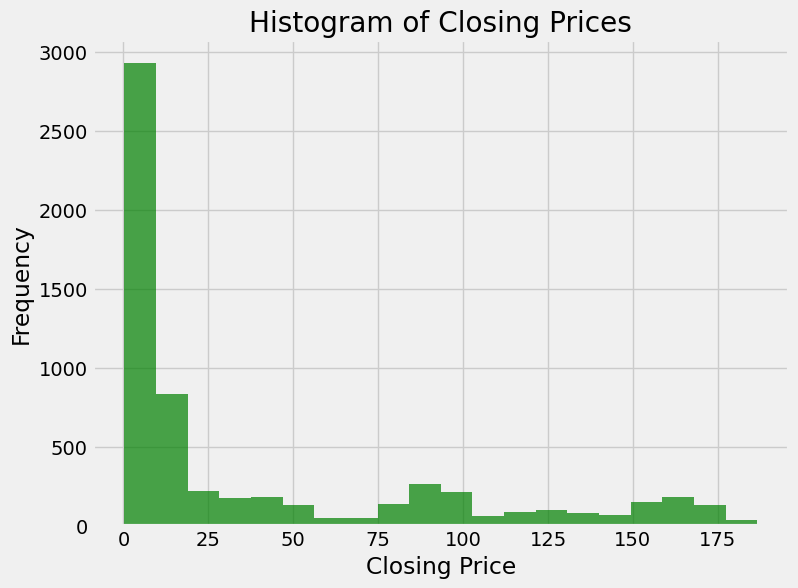

In [86]:
import matplotlib.pyplot as plt
# Histogram of closing prices
plt.figure(figsize=(8, 6))
plt.hist(dataset['Close'], bins=20, color='green', alpha=0.7)
plt.title('Histogram of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()


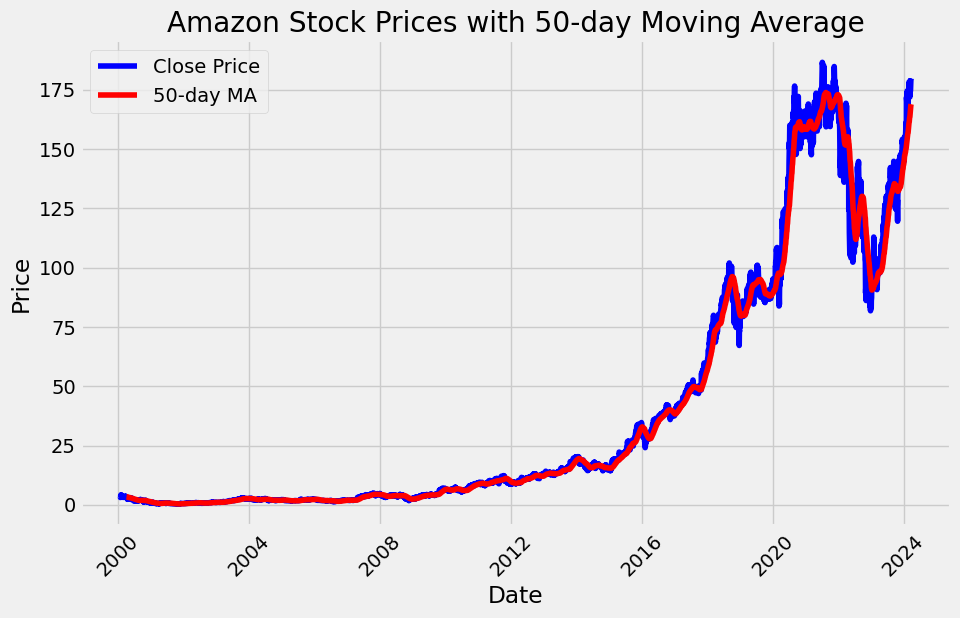

In [88]:
# Calculate 50-day moving average
dataset['50MA'] = dataset['Close'].rolling(window=50).mean()

# Plotting moving averages
plt.figure(figsize=(10, 6))
plt.plot(dataset['Close'], label='Close Price', color='blue')
plt.plot(dataset['50MA'], label='50-day MA', color='red')
plt.title('Amazon Stock Prices with 50-day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()


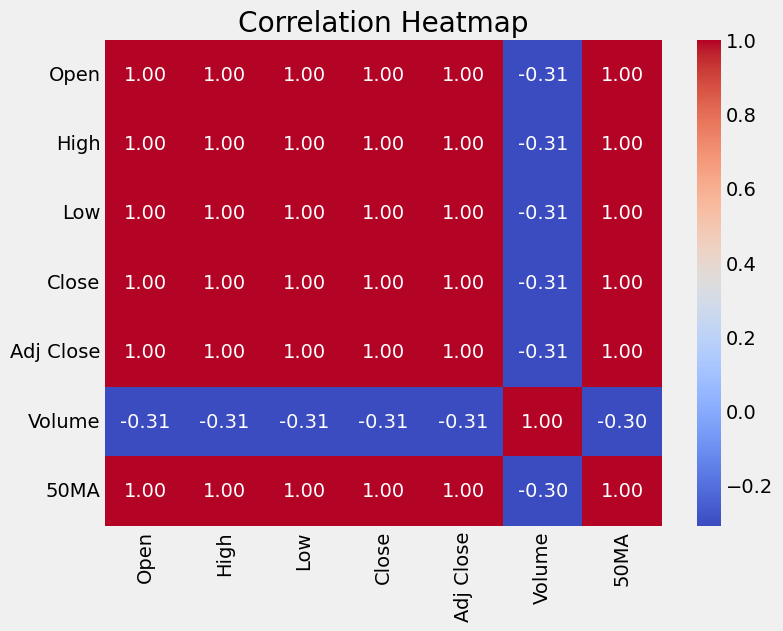

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn module

# Calculate correlation matrix
correlation_matrix = dataset.corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


##DATA SPLIT

In [5]:
# Checking for missing values
training_set = dataset[:'2022'].iloc[:,1:2].values
test_set = dataset['2022':].iloc[:,1:2].values

In [22]:
# Assuming test_dataset is a list
num_rows = len(test_set)
print("Number of rows in test dataset:", num_rows)


Number of rows in test dataset: 559


In [76]:
last_date = dataset.index[-1]
print("Last date of the dataset:", last_date)


Last date of the dataset: 2024-03-25 00:00:00


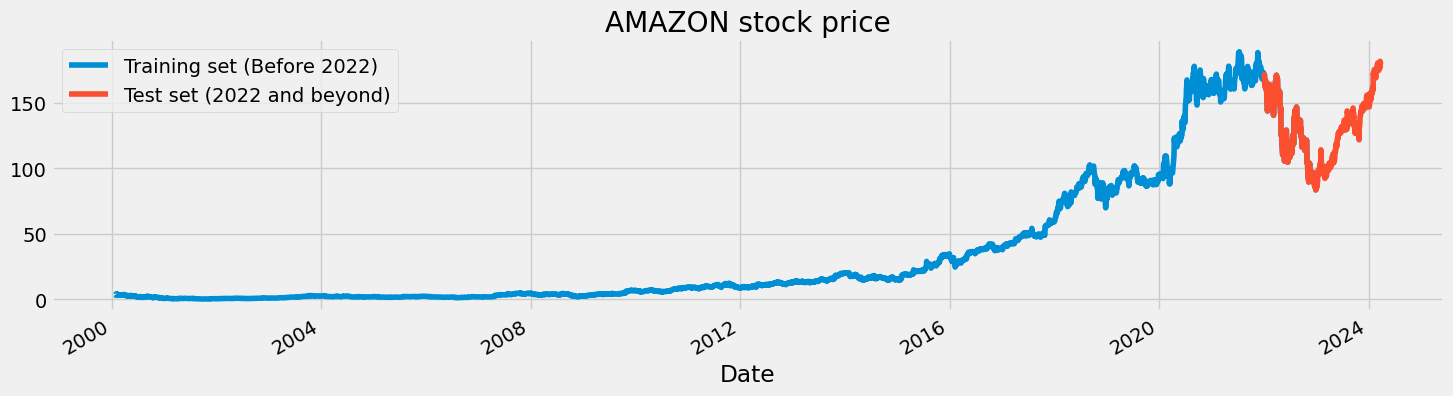

In [6]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2022'].plot(figsize=(16,4),legend=True)
dataset["High"]['2022':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2022)','Test set (2022 and beyond)'])
plt.title('AMAZON stock price')
plt.show()

In [7]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [10]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []
for i in range(60,5771):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [11]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

##LSTM MODEL

In [52]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
179/179 [==============================] - 8s 13ms/step - loss: 0.0050
Epoch 2/100
179/179 [==============================] - 2s 13ms/step - loss: 0.0026
Epoch 3/100
179/179 [==============================] - 2s 13ms/step - loss: 0.0024
Epoch 4/100
179/179 [==============================] - 3s 14ms/step - loss: 0.0021
Epoch 5/100
179/179 [==============================] - 3s 15ms/step - loss: 0.0020
Epoch 6/100
179/179 [==============================] - 2s 13ms/step - loss: 0.0017
Epoch 7/100
179/179 [==============================] - 2s 13ms/step - loss: 0.0016
Epoch 8/100
179/179 [==============================] - 2s 13ms/step - loss: 0.0015
Epoch 9/100
179/179 [==============================] - 3s 14ms/step - loss: 0.0014
Epoch 10/100
179/179 [==============================] - 2s 14ms/step - loss: 0.0015
Epoch 11/100
179/179 [==============================] - 2s 13ms/step - loss: 0.0014
Epoch 12/100
179/179 [==============================] - 2s 13ms/step - loss: 0.0014
E

In [53]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2022'],dataset["High"]['2022':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [54]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,619):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

18/18 [==============================] - 1s 8ms/step


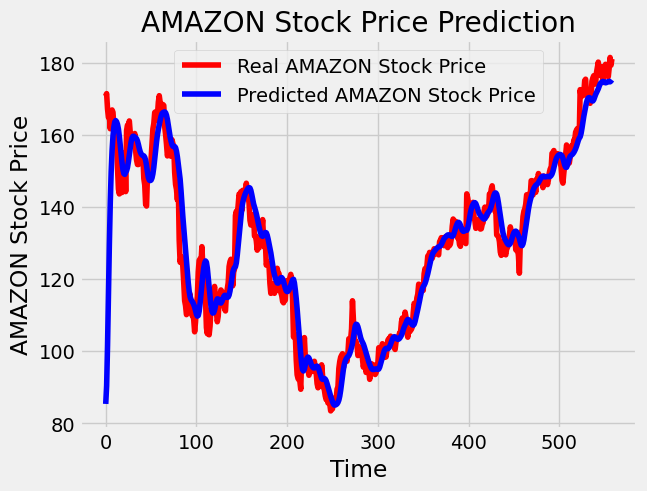

In [55]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [56]:
# Check the lengths of the test set and predicted values
print("Length of test set:", len(test_set))
print("Length of predicted values:", len(predicted_stock_price))


Length of test set: 559
Length of predicted values: 559


In [57]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 8.617141610675956.


#MODEL ANALYSIS:
*   with epoch 50, RMSE is 12
*   with epoch 100, RMSE is 8

Epoch and RMSE is inversly correlated.

##Gated Recurrent Units

In [67]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

# Define a learning rate schedule
def lr_schedule(epoch):
    lr = 0.01 * (0.1 ** (epoch // 10))
    return lr

# The GRU architecture
regressorGRU = Sequential()

# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

# The output layer
regressorGRU.add(Dense(units=1))

# Compiling the RNN with LearningRateScheduler
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False), loss='mean_squared_error')

# Fitting to the training set with LearningRateScheduler
regressorGRU.fit(X_train, y_train, epochs=100, batch_size=150, callbacks=[LearningRateScheduler(lr_schedule)])


Epoch 1/100
39/39 [==============================] - 7s 15ms/step - loss: 0.0390 - lr: 0.0100
Epoch 2/100
39/39 [==============================] - 1s 15ms/step - loss: 0.0027 - lr: 0.0100
Epoch 3/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0022 - lr: 0.0100
Epoch 4/100
39/39 [==============================] - 1s 16ms/step - loss: 0.0022 - lr: 0.0100
Epoch 5/100
39/39 [==============================] - 1s 16ms/step - loss: 0.0021 - lr: 0.0100
Epoch 6/100
39/39 [==============================] - 1s 14ms/step - loss: 0.0019 - lr: 0.0100
Epoch 7/100
39/39 [==============================] - 1s 16ms/step - loss: 0.0019 - lr: 0.0100
Epoch 8/100
39/39 [==============================] - 1s 16ms/step - loss: 0.0019 - lr: 0.0100
Epoch 9/100
39/39 [==============================] - 1s 16ms/step - loss: 0.0018 - lr: 0.0100
Epoch 10/100
39/39 [==============================] - 1s 16ms/step - loss: 0.0018 - lr: 0.0100
Epoch 11/100
39/39 [==============================] - 1s 18

In [68]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,619):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

18/18 [==============================] - 1s 7ms/step


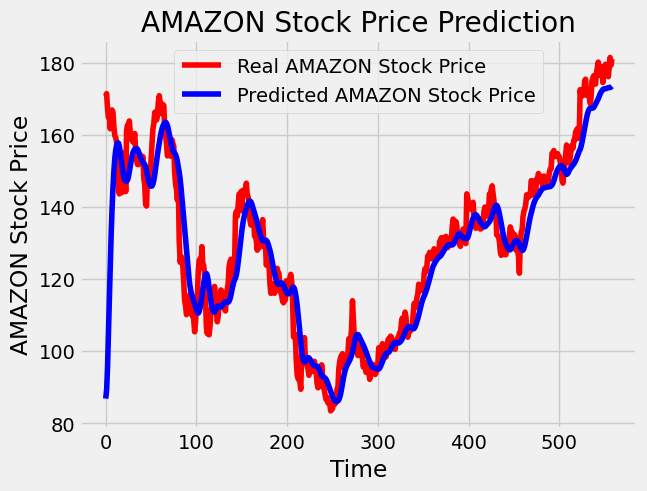

In [69]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [71]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 9.830124457472142.


#MODEL ANALYSIS:
*   with epoch 50,RMSE is 9
*   with epoch 100,RMSE remains same '9'.

###TO FORECAST THE FETURE WE WILL MOVE ON WITH LSTM MODEL.

In [79]:
# Number of future periods to forecast
num_periods = 250

# Initialize an empty list to store the forecasted prices
forecasted_prices = []

# Use the last 60 days from the training set to start forecasting
current_input = X_test[-1]

for i in range(num_periods):
    # Reshape the input for prediction
    current_input = current_input.reshape((1, X_test.shape[1], 1))

    # Predict the next day's stock price
    next_day_prediction = regressor.predict(current_input)

    # Store the prediction
    forecasted_prices.append(next_day_prediction[0, 0])

    # Update the input sequence for the next prediction
    current_input = np.roll(current_input, -1)
    current_input[-1] = next_day_prediction

# Convert the forecasted prices to original scale
forecasted_prices = sc.inverse_transform(np.array(forecasted_prices).reshape(-1, 1))

# Print the forecasted prices
print("Forecasted prices for the next 100 days:")
for i in range(len(forecasted_prices)):
    print(f"Day {i+1}: {forecasted_prices[i][0]}")


1/1 [==============================] - 0s 23ms/step
Forecasted prices for the next 100 days:
Day 1: 175.22596740722656
Day 2: 172.8109130859375
Day 3: 170.79931640625
Day 4: 169.1049041748047
Day 5: 167.66436767578125
Day 6: 166.43019104003906
Day 7: 165.36587524414062
Day 8: 164.4429473876953
Day 9: 163.63880920410156
Day 10: 162.93531799316406
Day 11: 162.31768798828125
Day 12: 161.77378845214844
Day 13: 161.29348754882812
Day 14: 160.8683624267578
Day 15: 160.49131774902344
Day 16: 160.15628051757812
Day 17: 159.8580780029297
Day 18: 159.59228515625
Day 19: 159.3551025390625
Day 20: 159.14320373535156
Day 21: 158.9536895751953
Day 22: 158.78404235839844
Day 23: 158.63206481933594
Day 24: 158.49583435058594
Day 25: 158.3736114501953
Day 26: 158.263916015625
Day 27: 158.16539001464844
Day 28: 158.07688903808594
Day 29: 157.99732971191406
Day 30: 157.92581176757812
Day 31: 157.86146545410156
Day 32: 157.8035888671875
Day 33: 157.75149536132812
Day 34: 157.70458984375
Day 35: 157.662384

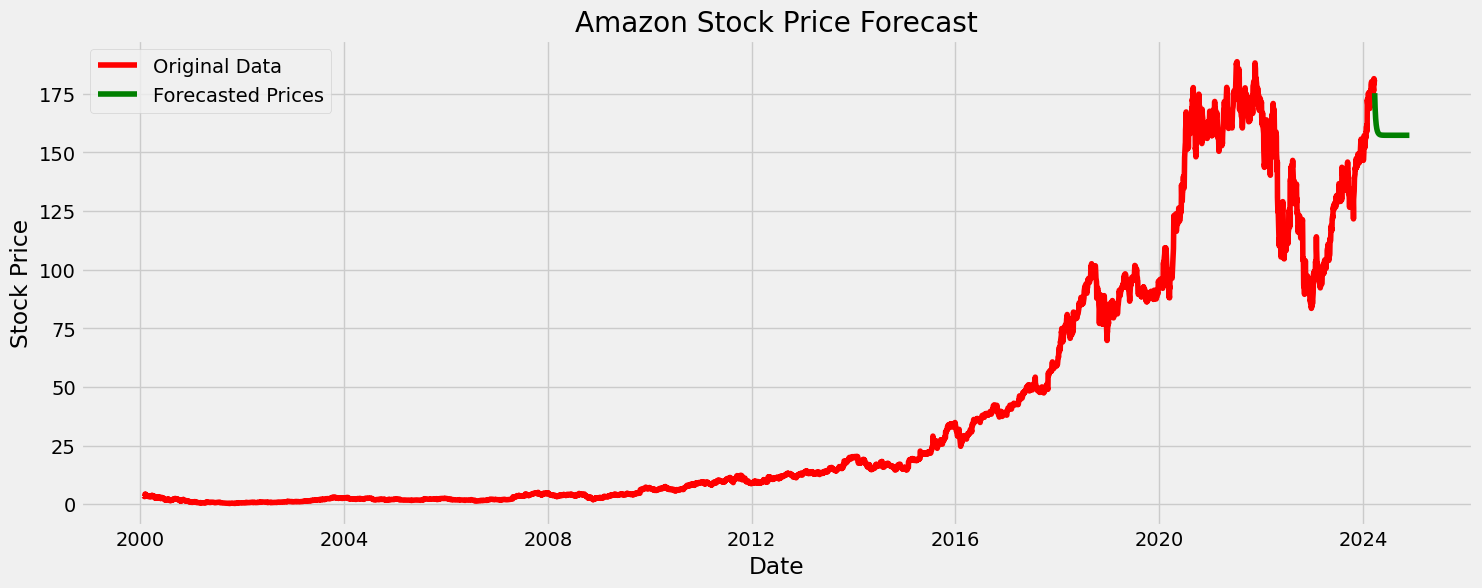

In [80]:
import matplotlib.pyplot as plt

# Plot the original data
plt.figure(figsize=(16, 6))
plt.plot(dataset["High"][:'2024-03-25'], color='RED', label='Original Data')

# Plot the forecasted data starting from the day after the last date of the dataset
forecasted_dates = pd.date_range(start='2024-03-26', periods=num_periods)
plt.plot(forecasted_dates, forecasted_prices, color='green', label='Forecasted Prices')

# Customize the plot
plt.title('Amazon Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


#Here red represents the original data and green represents the future forecasted data. forecasted price fall down firat and stabilized later.